In [2]:
from google.colab import drive ;
drive.mount('/content/drive') ;

Mounted at /content/drive


In [3]:
import os ;
import cv2 ;
import numpy as np ;
from os import listdir ;
import matplotlib.image as mpimg ;
import matplotlib.pyplot as plt ;
from skimage.color import rgb2lab, lab2rgb ;

In [4]:
sourceDirectory = "/content/drive/MyDrive/Landscape/landscape Images/color" ;
num_images = 7000 ;
images = [] ;

In [5]:
# I tried to make a subdirectory extractor
for image in os.listdir(sourceDirectory):
    if(image.endswith(".jpg")):
        data = mpimg.imread(sourceDirectory + '/' + image) ;
        data = cv2.resize(data, (128,128)) ;
        images.append(data) ;
        if(len(images) >= num_images):
          break ;

In [6]:
images = np.array(images, dtype='float32')/255 ;
images.shape

(7000, 128, 128, 3)

In [7]:
from sklearn.model_selection import train_test_split ;
xtrain, xtest = train_test_split(images, test_size=500) ;
del images ;

In [8]:
print('Training Images: ', xtrain.shape) ;
print('Testing Images: ', xtest.shape) ;

Training Images:  (6500, 128, 128, 3)
Testing Images:  (500, 128, 128, 3)


In [9]:
np.save('xtest.npy', xtest) ;
del xtest ;

In [10]:
import tensorflow as tf ;
from tensorflow.keras import layers, models ;
from tensorflow.keras.utils import plot_model ;

In [11]:
np.random.seed(123) ;
tf.random.set_seed(123) ;
device = tf.test.gpu_device_name() ;
device

'/device:GPU:0'

In [12]:
# Down sampler CNN network
def downCNN(name, filters, kernel_size, batchNormalization = True):
    downsampler = models.Sequential() ;
    downsampler._name = name ;
    downsampler.add(layers.Conv2D(filters, kernel_size, padding = 'same', strides = 2)) ;
    if batchNormalization: downsampler.add(layers.BatchNormalization()) ;
    downsampler.add(layers.LeakyReLU()) ;
    return downsampler ;

In [13]:
def upCNN(name, filters, kernel_size, normalize=True, dropOut = True):
    upsampler = models.Sequential() ;
    upsampler._name = name ;
    upsampler.add(layers.Conv2DTranspose(filters, kernel_size, padding = 'same', strides = 2)) ;
    if normalize: upsampler.add(layers.BatchNormalization()) ;
    if dropOut: upsampler.add(layers.Dropout(0.2)) ;
    upsampler.add(layers.LeakyReLU()) ;
    return upsampler ;

In [14]:
def AutoEncoder():
    # Input grayscale images of dimensions 128*128
    image = layers.Input(shape = [128,128,1]) ;

    # Feed it to an encoder network for downsampling to a latent vector
    d1 = downCNN("Downsampler_1", 128,(3,3),False)(image) ;
    d2 = downCNN("Downsampler_2", 128,(3,3),True)(d1) ;
    d3 = downCNN("Downsampler_3", 256,(3,3),True)(d2) ;
    d4 = downCNN("Downsampler_4", 512,(3,3),True)(d3) ;
    d5 = downCNN("Downsampler_5", 512,(3,3),True)(d4) ;

    # Decode the latent vector to upscale into large image matrix
    u1 = upCNN("Upsampler_1", 512,(3,3),True,False)(d5) ;
    u1 = layers.concatenate([u1,d4]) ;
    u2 = upCNN("Upsampler_2", 256,(3,3),True,False)(u1) ;
    u2 = layers.concatenate([u2,d3]) ;
    u3 = upCNN("Upsampler_3", 128,(3,3),True,True)(u2) ;
    u3 = layers.concatenate([u3,d2]) ;
    u4 = upCNN("Upsampler_4", 128,(3,3),True,False)(u3) ;
    u4 = layers.concatenate([u4,d1]) ;
    u5 = upCNN("Upsampler_5", 3,(3,3),False,False)(u4) ;
    u5 = layers.concatenate([u5,image]) ;

    # Generate colored images with final convolution
    output = layers.Conv2D(3, (2,2), strides = 1, padding = 'same')(u5) ;
    return models.Model(inputs=image, outputs=output) ;

In [15]:
colorizer = AutoEncoder() ;
plot_model(colorizer, to_file='colorizerUsingAutoEncoder128*128.png', show_shapes=True) ;
print(colorizer.summary()) ;

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 Downsampler_1 (Sequential)  (None, 64, 64, 128)          1280      ['input_1[0][0]']             
                                                                                                  
 Downsampler_2 (Sequential)  (None, 32, 32, 128)          148096    ['Downsampler_1[0][0]']       
                                                                                                  
 Downsampler_3 (Sequential)  (None, 16, 16, 256)          296192    ['Downsampler_2[0][0]']       
                                                                                              

Dataset Analysis & Preprocessing

In [16]:
def showImage(data, index, label=None):
  plt.figure(figsize=(0.5, 0.5)) ;
  plt.imshow(data[index]) ;
  if label != None:
    plt.xlabel('Human') ;

In [17]:
def random_color_augmentation(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV) ;
    # Randomly adjust the hue, saturation, and value of the image.
    hue_delta = np.random.uniform(-0.5, 0.5) ; # Hue changes the color scale so, I think it confuses the model more than challenging it so, change it by only a bit !
    saturation_delta = np.random.uniform(0.5, 1.5) ;
    value_delta = np.random.uniform(0.5, 1.5) ;
    # Apply the random deltas to the image
    hue = np.add(image[:, :, 0], hue_delta) ;
    saturation = np.multiply(image[:, :, 1], saturation_delta) ;
    value = np.multiply(image[:, :, 2], value_delta) ;
    # Clip the adjusted values to the 0-1 range
    hue = np.clip(hue, 0, 180) ;
    saturation = np.clip(saturation, 0, 1) ;
    value = np.clip(value, 0, 1) ;
    # Convert the adjusted channels back to RGB color space
    augmented_image = cv2.cvtColor(np.stack([hue, saturation, value], axis=2), cv2.COLOR_HSV2RGB) ;
    return augmented_image ;

In [18]:
augmentedImages = np.zeros(shape=(3500, 128,128,3), dtype=np.float32) ;
for i in range(augmentedImages.shape[0]):
  augmentedImages[i] = random_color_augmentation(xtrain[i]) ;
augmentedImages.shape

(3500, 128, 128, 3)

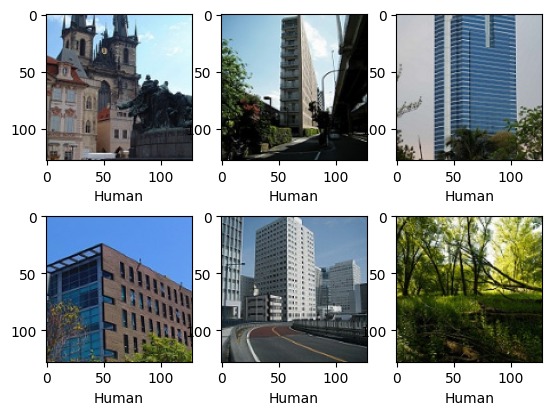

In [19]:
figure, axes = plt.subplots(2, 3) ;
for i in range(6):
    axes[int(i/3)][int(i%3)].imshow(xtrain[i]) ;
    axes[int(i/3)][int(i%3)].set_xlabel('Human') ;
plt.show() ;

<ipython-input-20-c751df60e94b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure, axes = plt.subplots(1,1, figsize=(3,1)) ;


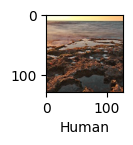

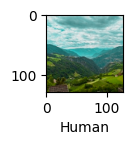

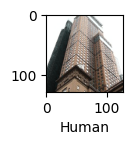

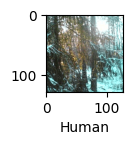

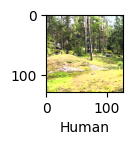

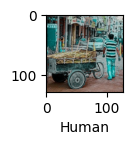

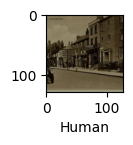

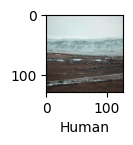

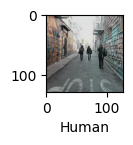

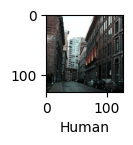

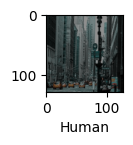

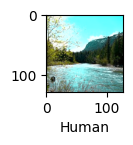

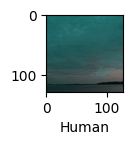

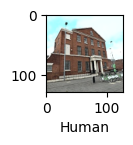

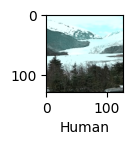

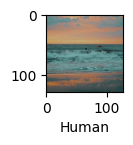

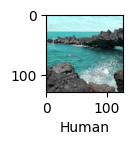

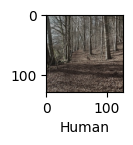

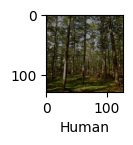

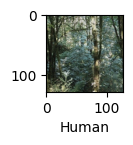

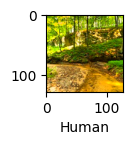

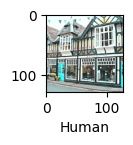

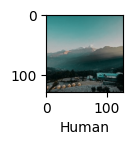

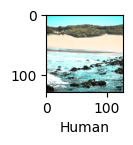

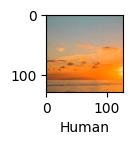

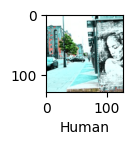

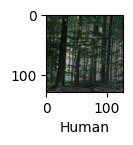

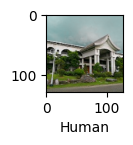

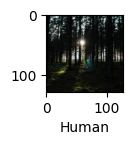

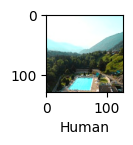

In [20]:
randomIndex = np.random.randint(low=0, high=1000, size=30) ;
for i in randomIndex:
  figure, axes = plt.subplots(1,1, figsize=(3,1)) ;
  axes.imshow(augmentedImages[i]) ;
  axes.set_xlabel('Human') ;
plt.show() ;

In [21]:
xtrain = np.concatenate((xtrain, augmentedImages), axis=0) ;
del augmentedImages ;
print(xtrain.shape) ;

(10000, 128, 128, 3)


In [22]:
def rgb2gray(rgb):
    value = np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140]) ;
    return value ;

In [23]:
xtrainG = np.zeros((xtrain.shape[0],128,128)).astype(np.float32) ;
for i in range(xtrain.shape[0]):
  xtrainG[i] = rgb2gray(xtrain[i]) ;

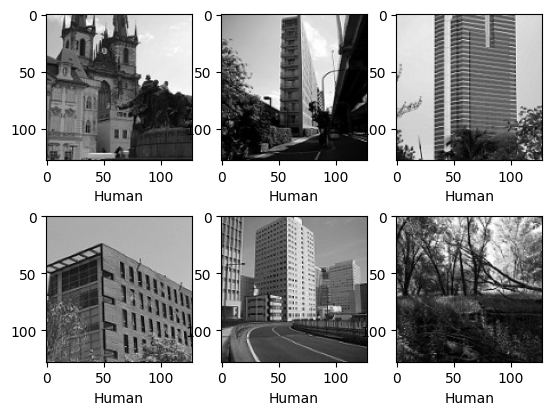

In [24]:
figure, axes = plt.subplots(2, 3) ;
for i in range(6):
    axes[int(i/3)][int(i%3)].imshow(xtrainG[i], cmap='gray') ;
    axes[int(i/3)][int(i%3)].set_xlabel('Human') ;
plt.show() ;

Model Training & Evaluation

In [25]:
colorizer.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00075), loss = 'mean_absolute_error', metrics = ['accuracy']) ;
colorizer

In [26]:
# !!! WARNING: This optimizes CPU performance - DON'T USE THIS WHEN GPU IS ENABLED !!! (Learnt the hard way!)
# tf.config.run_functions_eagerly(True) ; #  IT ENABLES CONVOLUTION LAYER TO FUNCTION EARLY CAUSING ISSUES IN TENSORS IF GPU IS USED
# tf.data.experimental.enable_debug_mode() ; # IT DISABLES PARALLELISM AND FORCES SEQUENTIAL OPERATION

In [27]:
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5) ;
history = colorizer.fit(xtrainG, xtrain, epochs = 200, batch_size = 50, validation_split=0.05, shuffle=True, verbose = True) ;

Epoch 1/200
190/190 [==============================] - 54s 189ms/step - loss: 0.1120 - accuracy: 0.3781 - val_loss: 0.1412 - val_accuracy: 0.3801
Epoch 2/200
190/190 [==============================] - 35s 187ms/step - loss: 0.0662 - accuracy: 0.4307 - val_loss: 0.0976 - val_accuracy: 0.4037
Epoch 3/200
190/190 [==============================] - 36s 188ms/step - loss: 0.0603 - accuracy: 0.4458 - val_loss: 0.0644 - val_accuracy: 0.4204
Epoch 4/200
190/190 [==============================] - 36s 189ms/step - loss: 0.0566 - accuracy: 0.4548 - val_loss: 0.0730 - val_accuracy: 0.3769
Epoch 5/200
190/190 [==============================] - 36s 191ms/step - loss: 0.0546 - accuracy: 0.4631 - val_loss: 0.0706 - val_accuracy: 0.3790
Epoch 6/200
190/190 [==============================] - 36s 192ms/step - loss: 0.0526 - accuracy: 0.4713 - val_loss: 0.0698 - val_accuracy: 0.3511
Epoch 7/200
190/190 [==============================] - 37s 192ms/step - loss: 0.0510 - accuracy: 0.4881 - val_loss: 0.0753 -

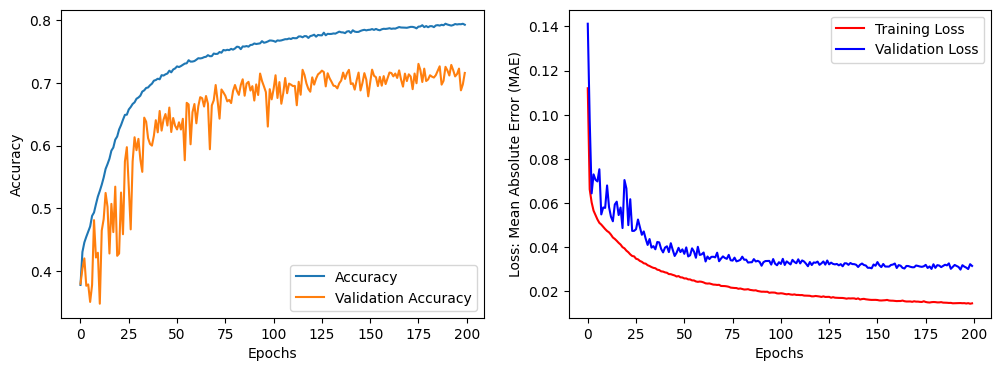

In [28]:
figure, axes = plt.subplots(1,2, figsize=(12,4)) ;
axes[0].plot(history.history['accuracy'], label='Accuracy') ;
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy') ;
axes[0].set_xlabel('Epochs') ;
axes[0].set_ylabel('Accuracy') ;
axes[0].legend() ;
axes[1].plot(history.history['loss'], color='red', label='Training Loss') ;
axes[1].plot(history.history['val_loss'], color='blue', label='Validation Loss') ;
axes[1].set_xlabel('Epochs') ;
axes[1].set_ylabel('Loss: Mean Absolute Error (MAE)') ;
axes[1].legend() ;
plt.show() ;

In [29]:
!pip install pyyaml h5py
colorizer.save('autoEncoderCNN_colorizer_linnaeus5.h5') ;
colorizer.save('autoEncoderCNN_colorizer_linnaeus5.keras') ;

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
del xtrain ;
xtest = np.load("xtest.npy") ;

In [31]:
xtestG = np.zeros((xtest.shape[0],128,128)).astype(np.float32) ;
for i in range(xtest.shape[0]):
  xtestG[i] = rgb2gray(xtest[i]) ;

In [32]:
colorizer.evaluate(xtestG, xtest) ;

16/16 [==============================] - 3s 93ms/step - loss: 0.0486 - accuracy: 0.5059


Model Prediction & Output Overview

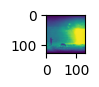

In [33]:
showImage(xtestG, 0) ;

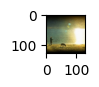

In [34]:
showImage(xtest, 0) ;

In [35]:
coloredOutput = colorizer.predict(xtestG[0].reshape(1,128,128,1)) ;

1/1 [==============================] - 1s 965ms/step


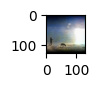

In [36]:
coloredOutput = coloredOutput.astype(np.float32) ;
showImage(coloredOutput, 0) ;

1/1 [==============================] - 0s 17ms/step


<ipython-input-37-34351ee5942c>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure, axes = plt.subplots(1,3, figsize=(6,1)) ;


1/1 [==============================] - 0s 17ms/step


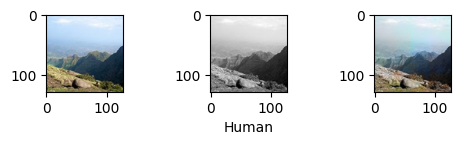

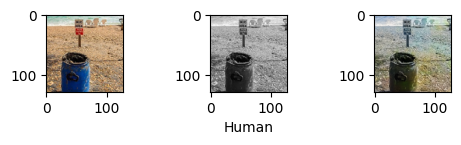

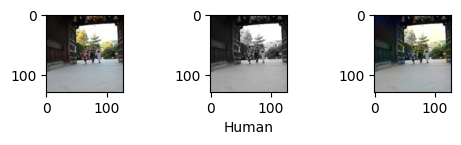

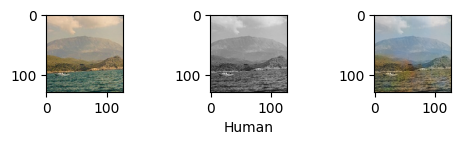

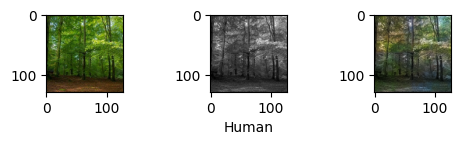

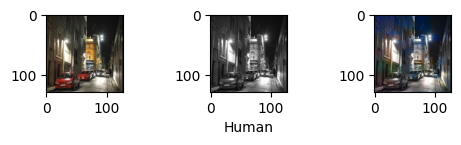

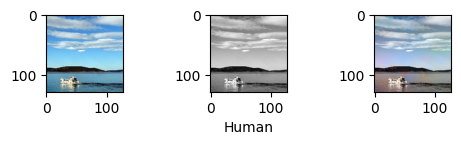

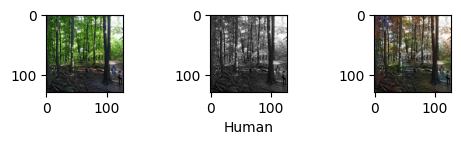

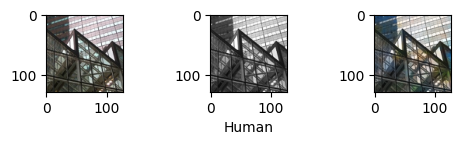

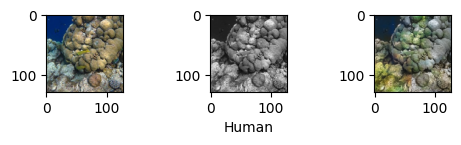

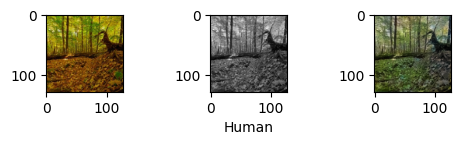

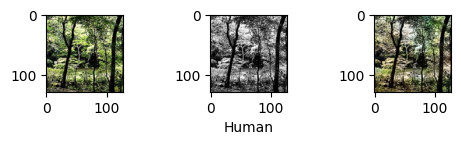

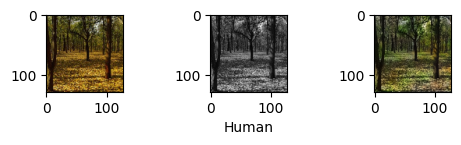

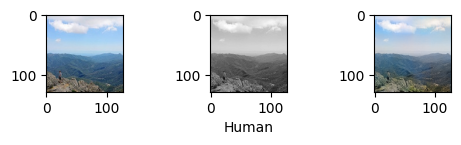

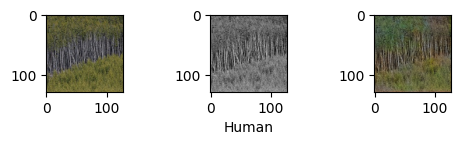

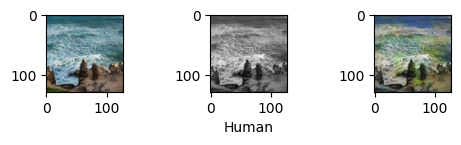

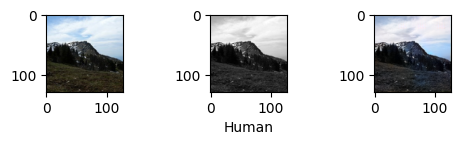

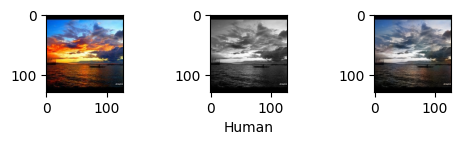

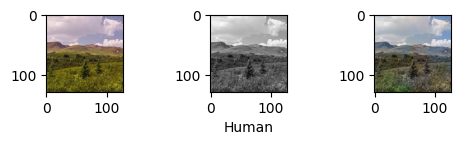

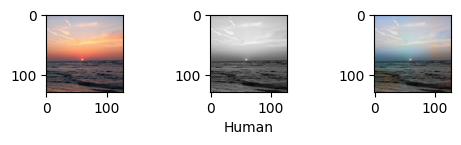

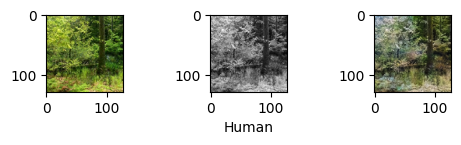

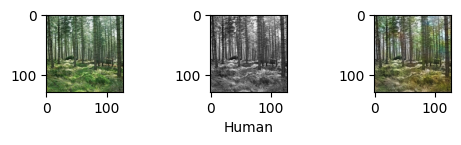

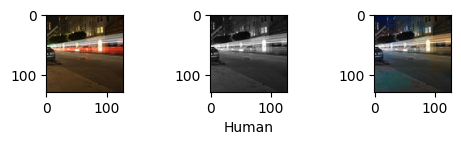

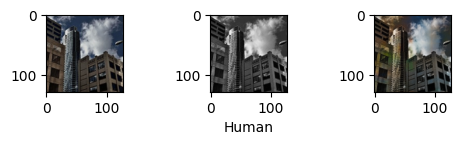

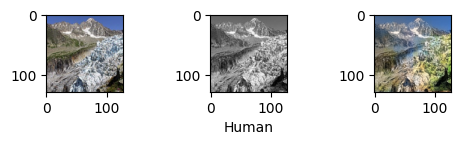

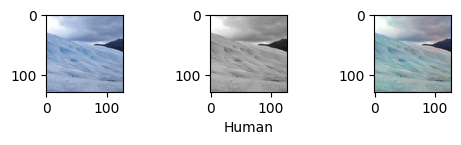

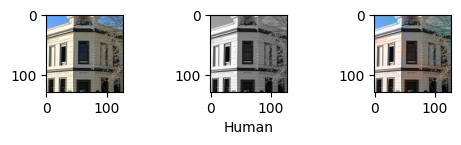

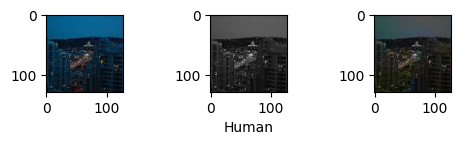

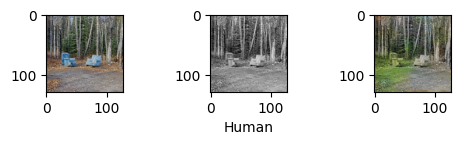

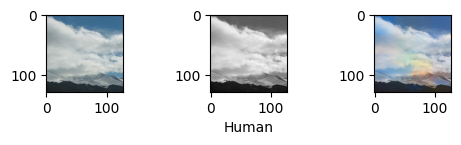

In [37]:
randomIndex = np.random.randint(low=0, high=500, size=30) ;
for i in randomIndex:
  output = colorizer.predict(xtestG[i].reshape(1,128,128,1)) ;
  output = np.clip(output, 0.0, 1.0).astype(np.float32) ;
  figure, axes = plt.subplots(1,3, figsize=(6,1)) ;
  axes[0].imshow(xtest[i]) ;
  axes[1].imshow(xtestG[i], cmap='gray') ;
  axes[1].set_xlabel('Human') ;
  axes[2].imshow(output[0]) ;
plt.show() ;